### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

Creating df for short GRB
Absolute time correction subtracted from T0
197 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 326 flags
Removed 326 flags from df
df sorted by tus
2018-12-22 20:11:36.576228
first tus:  -125368.36111111111 | max tus:  1884603.388888889
26423
tus array OK ...


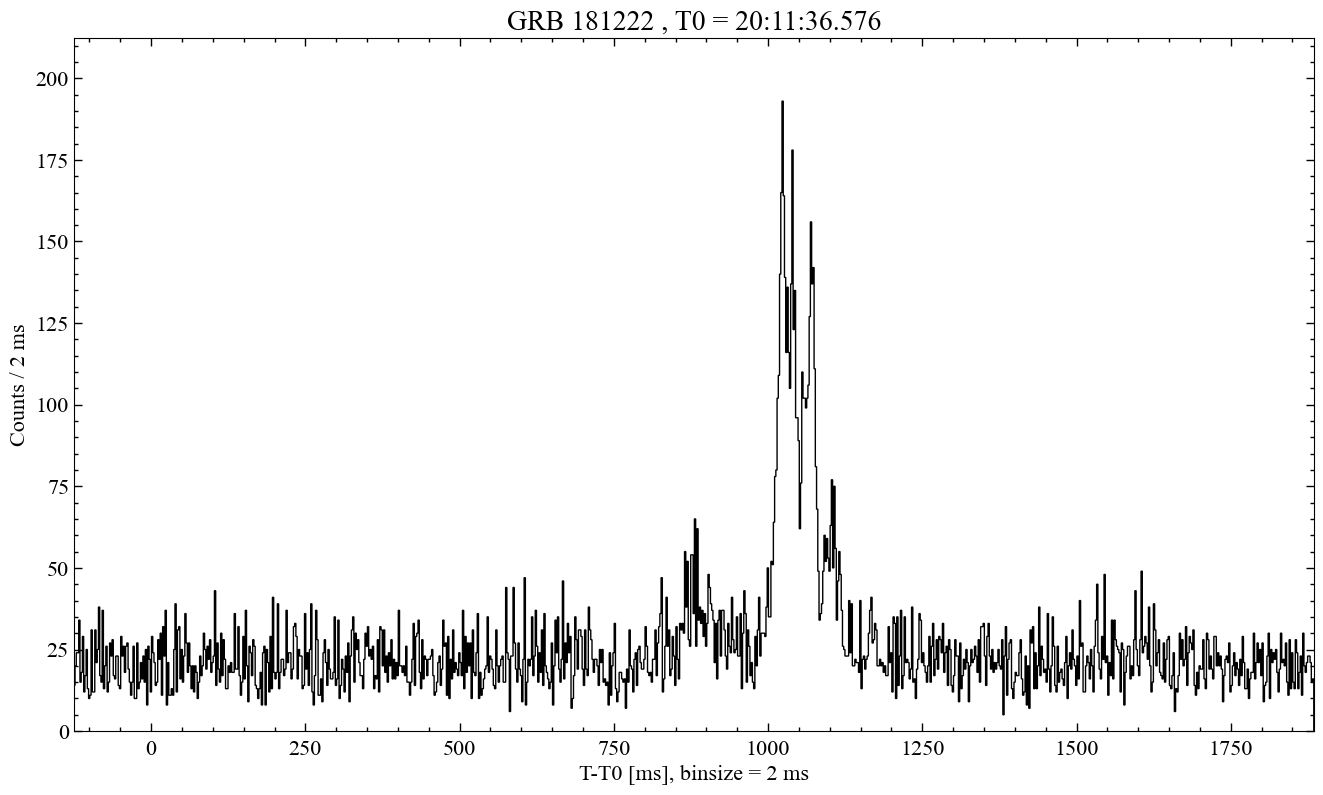

In [3]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB181222",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

0.512


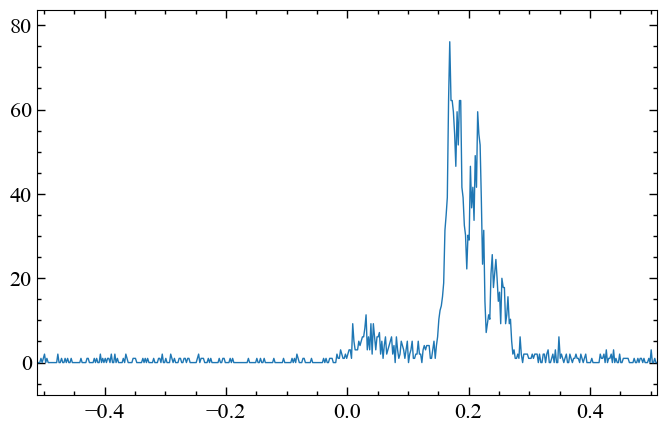

In [126]:
kw_filename = "GRB181222B_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
ToF = 2.8716


kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

In [162]:
kw_lc.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 181222B KW 300-1160 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorralation/KW_originalLC.png")

# CrossCorr
    TODO:
        -Make a function for finding the optimal tlagg
        -run the laggs array containing all of the possible tlaggs.
        -Time range (+- 200 ms) selected from peak count rate pr bin

### ASIM prep

In [156]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 300<=kev<=1160:
        indexInBound.append(i)
kevArr = kevArr[indexInBound]
tus = tus[indexInBound]

laggApprox = 0.0    
tus += laggApprox

asim_binsOrg = np.round(np.arange(-0.5,2,binsize,dtype=np.float32),3)

hist = np.histogram(tus,bins=asim_binsOrg)
asimCounts,asimEdges = hist[0],hist[1]
asimLC = LC(time=np.round(asimEdges[:-1],3)+binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)

In [163]:
asimLC.plot(labels=["T-T0 [s]","counts/2ms"],title="GRB 181222B ASIM 300-1160 keV",
            save=True,filename="/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorralation/ASIM_originalLC.png")

### LC approx compare and tlagg

In [33]:
kwCompare,asimCompare = CompareLC(kw_lc=kw_lc,asim_lc=asimLC,binsize=binsize)
#CompareLC actually cuts correctly kw if asim LC is "short"
CC = CrossCorrelation(kwCompare,asimCompare,mode="full")
CClagg=CC.time_shift
tlagg = laggApprox + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
kwFinal,asimFinal = CompareLC(kw_lc=kw_lc,asim_lc=asimLC.shift(CClagg),binsize=binsize,okReturn=True)

Total lagg (s):  -0.852734375 | CC lagg:  -0.052734375


/Home/siv30/wad005/anaconda3/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


### Approx shift

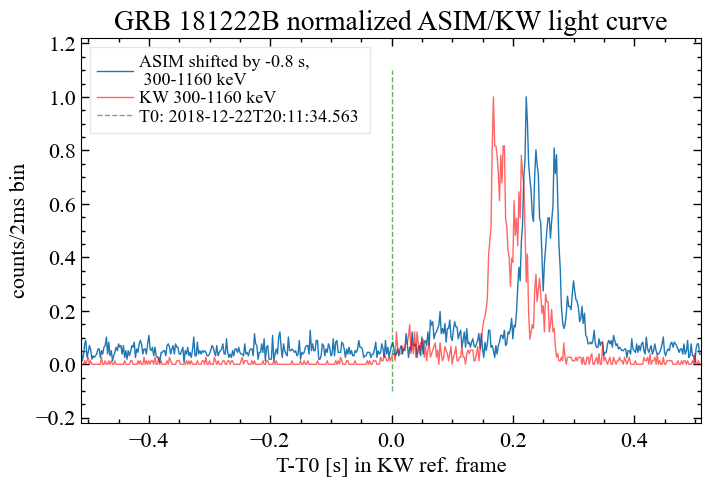

In [171]:
T0_approx = T0_ASIM+timedelta(seconds=laggApprox)

plt.plot(np.round(asimCompare.bin_lo,3),asimCompare.counts/max(asimCompare),label="ASIM shifted by -0.8 s, \n 300-1160 keV")
plt.plot(np.round(kwCompare.bin_lo,3),kwCompare.counts/max(kwCompare),c="r",alpha=0.6,label="KW 300-1160 keV")

plt.title("GRB 181222B normalized ASIM/KW light curve")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {} ".format(T0_KW.isoformat(timespec='milliseconds')),alpha=0.6,linestyle="--")
plt.legend()
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorralation/ASIM_KW_AppShift.png")
plt.show()

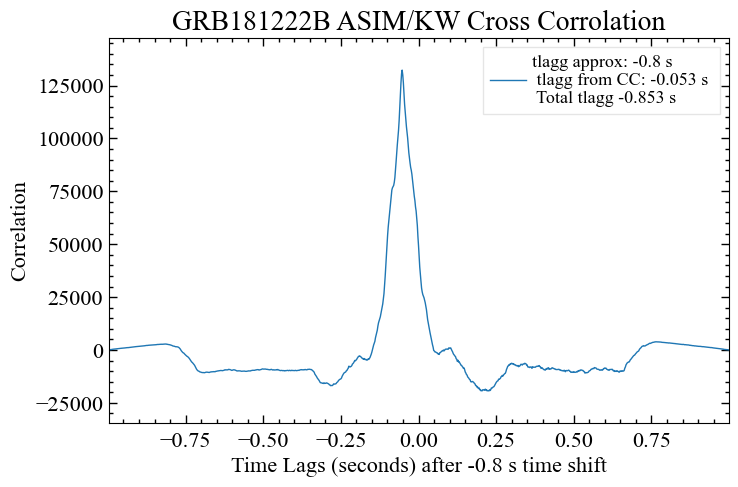

In [146]:
plt.plot(CC.time_lags,CC.corr,label="tlagg approx: {} s \n tlagg from CC: {} s \n Total tlagg {} s".format(np.round(laggApprox,3), np.round(CClagg,3), np.round(tlagg,3)))
plt.title("GRB181222B ASIM/KW Cross Corrolation")
plt.xlabel('Time Lags (seconds) after -0.8 s time shift')
plt.ylabel('Correlation')
plt.legend()
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorralation/CC_asim_kw.png")
plt.show()

### Final LC

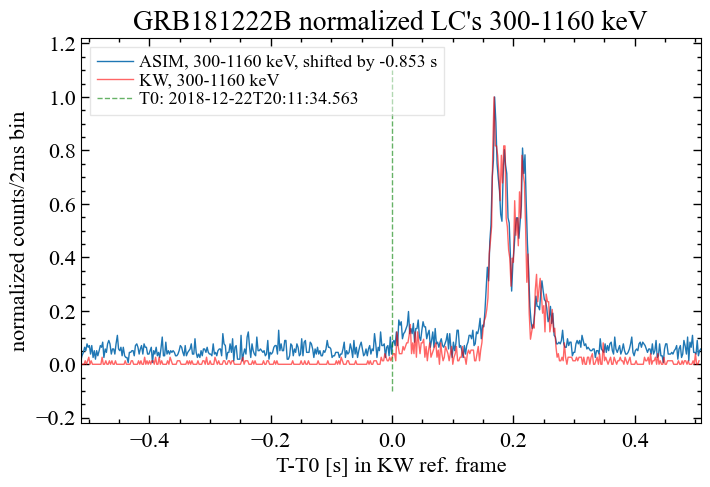

In [168]:
T0_final = T0_ASIM+timedelta(seconds=tlagg)
T0_KW = datetime.strptime("2018-12-22 20:11:34.563","%Y-%m-%d %H:%M:%S.%f")

i_asimStart = find_nearest(asimFinal.bin_lo,kwCompare.bin_lo[0])
i_kwEnd = find_nearest(kwCompare.bin_lo,asimFinal.bin_lo[-1])

plt.plot(np.round(asimFinal.bin_lo[i_asimStart:],3),asimFinal.counts[i_asimStart:]/max(asimFinal.counts),label="ASIM, 300-1160 keV, shifted by -0.853 s")
plt.plot(np.round(kwCompare.bin_lo[:i_kwEnd],3),kwCompare.counts[:i_kwEnd]/max(kwCompare.counts),c="r",alpha=0.6,label="KW, 300-1160 keV")

plt.title("GRB181222B normalized LC's 300-1160 keV")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
plt.vlines(x=0.0,ymin=-0.1,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
plt.savefig("/Home/siv30/wad005/master/GRB/xspec/GRB181222B/CrossCorralation/overlappingLC_asim_kw.png")
plt.show()


### Time difference (ToF & tlaggg)

In [139]:
T0_KW = datetime.strptime("2018-12-22 20:11:34.563","%Y-%m-%d %H:%M:%S.%f")
print(T0_ASIM+timedelta(seconds=-ToF-tlagg)) #ToF: 2.8716 s
print("Good to get the T0-KW after applying ToF and tlagg to T0_ASIM")
print("Still 6ms difference but lc's have the highest corr for tlagg = -0.853 s")

2018-12-22 20:11:34.557362
Good to get the T0-KW after applying ToF and tlagg to T0_ASIM
Still 6ms difference but lc's have the highest corr for tlagg = -0.853 s


# Extracting ASIM data

In [172]:
ASIM_df,T0 = complete_df(grb_id="GRB181222",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
197 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 326 flags
Removed 326 flags from df
df sorted by tus


tus array OK ...


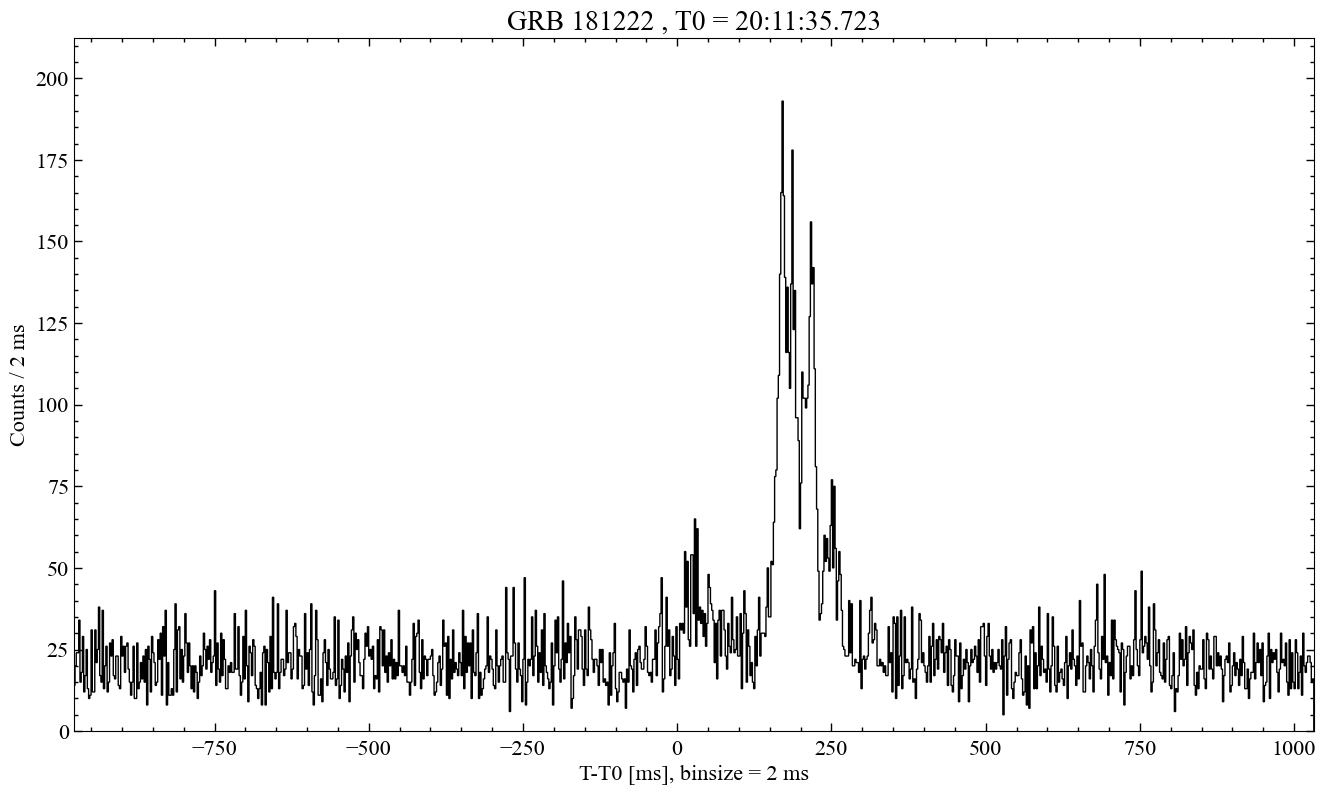

In [173]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=2)

In [ ]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
keV_df
#All triggers in the time_interval are kept

In [ ]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

### bakground extraction 

keV_bg = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.3),
                 keV_interval="max",
                 duration=0.6,
                 )

In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')